# Evaluation of Function Approximation using holdout

This Notebook builds on top of the `dataloader-example` and demonstrates
1. Evaluating NN using Holdout validation for 1D data

In [23]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from utils import plot

In [24]:
# %matplotlib widget
%matplotlib inline

## Network Definition

In [25]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam,
        use_grad=False,
        act_func=nn.LeakyReLU()):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True),
                nn.LeakyReLU(),
                nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)
            )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        self.use_grad = use_grad
        
    def forward(self, x):
        out = self.layers(x)
        return out

    def loss(self, x, y, y_grad=None):
        out = self.forward(x)
        loss = self.loss_func(y, out)
        if self.use_grad:
            out_grad = torch.autograd.grad(out, x, torch.ones(x.shape), create_graph=True)[0]
            loss += self.loss_func(y_grad, out_grad)
        return loss
    
    def step(self, x, y, y_grad=None):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, y, y_grad)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss.detach()

## 1D

### Define Dataset 

In [26]:
from DatasetFunction1D import DatasetFunction1D

x = torch.linspace(-1,1, 100, requires_grad=True).reshape(-1,1)
dataset = DatasetFunction1D(x)
_, y, y_grad = dataset[:]

N_in = x.shape[1]
N_out = y.shape[1]

### Holdout Validation

In [27]:
batch_size = 10
epochs = 100

In [28]:
from torch.utils.data import DataLoader
from sklearn.model_selection import ShuffleSplit
from torch.utils.data import SubsetRandomSampler

# Split dataset into train and test set (without stratification).
shuffleSplit = ShuffleSplit(n_splits=1, test_size=.25).split(x)
train_ids, test_ids = next(iter(shuffleSplit))

train_sampler = SubsetRandomSampler(train_ids)
train_loader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=batch_size,
                    sampler=train_sampler)

In [29]:
losses_train = torch.zeros(epochs)
losses_test = torch.zeros(epochs)

net = Net(N_in, N_out, N_hid=100, use_grad=True)

for epoch in range(epochs):
    current_loss = 0.0
    for i, batch in enumerate(train_loader):
        x_train, y_train, y_train_grad = batch
        current_loss += net.step(x_train, y_train, y_train_grad)
    losses_train[epoch] = current_loss / len(train_loader)
    
    # Evaluation against test set
    x_test, y_test, y_grad_test = dataset[test_ids]
    losses_test[epoch] = net.loss(x_test, y_test, y_grad_test)

### Evaluation

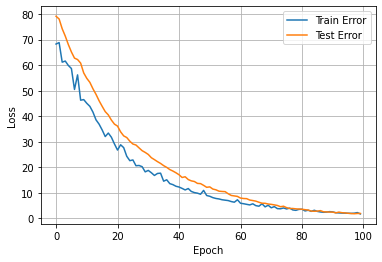

In [30]:
plot(range(epochs), losses_train)
plot(range(epochs), losses_test)
plt.legend(['Train Error', 'Test Error'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [31]:
print("Training Error: {:.3f}".format(losses_train[-1]))
print("Test Error: {:.3f}".format(losses_test[-1]))

Training Error: 1.759
Test Error: 1.929


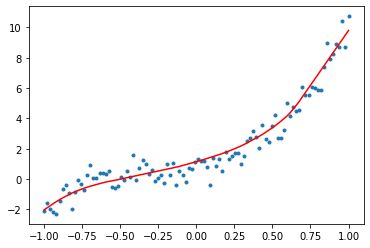

In [32]:
out = net(x)
plot(x, y, '.')
plot(x, out, 'r')
plt.show()

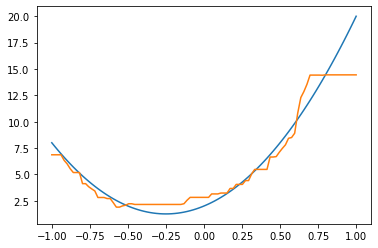

In [33]:
out_grad = torch.autograd.grad(net(x), x, torch.ones(x.shape))[0]

plot(x,y_grad)
plot(x,out_grad)
plt.show()